### Here we study the photometry noise based on the GAMA catalog

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import torch
import corner
import os

In [3]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.utils import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [43]:
PHOT = 'PETRO'

In [51]:
gama_cat = Table.read('./reference_catalog/GAMA/DR3ApMatchPhotStellarMass.fits')
print(len(gama_cat))

filters = list('ugrizYJHK')
mags = np.vstack([gama_cat[col].data for col in [f'MAG_{PHOT}_{filt}' for filt in filters]]).T
mags_err = np.vstack([gama_cat[col].data for col in [f'MAGERR_{PHOT}_{filt}' for filt in filters]]).T
fluxes = np.vstack([gama_cat[col].data for col in [f'FLUX_{PHOT}_{filt}' for filt in filters]]).T
fluxes_err = np.vstack([gama_cat[col].data for col in [f'FLUXERR_{PHOT}_{filt}' for filt in filters]]).T

flag = np.all((mags != 99.0), axis=1) & np.all((mags != -9999.0), axis=1) & np.all((mags != -99.0), axis=1)
flag &= np.all(fluxes_err > 0, axis=1)
flag &= np.all(fluxes > 0, axis=1)
flag &= ((mags[:, 6] - mags[:, 8]) > 0.025) #& (mags[:, 2] < 19.65)
flag &= (mags[:, 0] < 90)# & (mags[:, 0] < 25)
flag &= (gama_cat['logmintsfh'] > 0) # exclude -99.0
flag &= (mags[:, 0] < 30)

gama_cat = gama_cat[flag]
print(len(gama_cat))

120739
97859


In [45]:
filters = list('ugrizYJHK')
mags = np.vstack([gama_cat[col].data for col in [f'MAG_{PHOT}_{filt}' for filt in filters]]).T
mags_err = np.vstack([gama_cat[col].data for col in [f'MAGERR_{PHOT}_{filt}' for filt in filters]]).T

filters = list('ugrizYJHK')
fluxes = np.vstack([gama_cat[col].data for col in [f'FLUX_{PHOT}_{filt}' for filt in filters]]).T
fluxes_err = np.vstack([gama_cat[col].data for col in [f'FLUXERR_{PHOT}_{filt}' for filt in filters]]).T

zp = 30

In [46]:
logsnrs = np.log10(fluxes / fluxes_err)

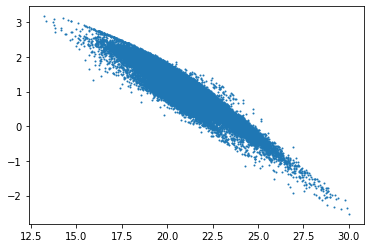

In [47]:
# plt.scatter(mags[:, 0], np.log10(fluxes[:, 0] / fluxes_err[:, 0]), s=1)
# plt.scatter(mags[:, 1], np.log10(fluxes[:, 1] / fluxes_err[:, 1]), s=1)
plt.scatter(mags[:, 0], logsnrs[:, 0], s=1)

# plt.xlim(-40, 100)
# plt.yscale('log')

In [48]:
z_mass_met = np.vstack([gama_cat['Z'], gama_cat['logmintsfh'], 
                        np.log10(gama_cat['metal']) - np.log10(0.0190)  - 0.8]).T

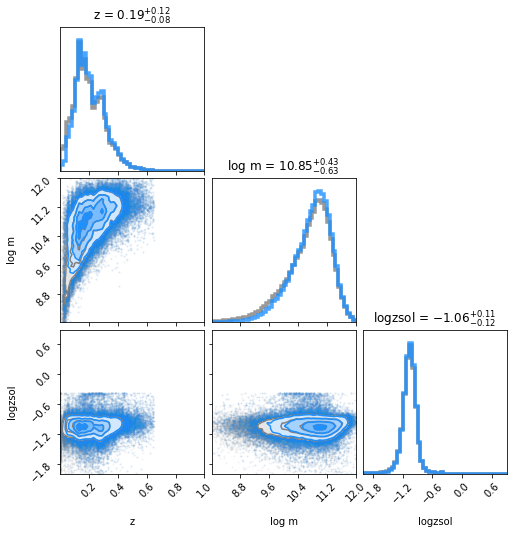

In [50]:
import corner
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=50,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.1, fill_contours=True,
                       range=[[0, 1], [8, 12], [-2, 0.9]], 
                       lw=1,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# figure = corner.corner(z_mass_met[flag], 
#                        fig=figure,
#                   labels=['z', 'log m', 'logzsol'], bins=50,
#                   color='dodgerblue',
#                        range=[[0, 1], [8, 12], [-2, 0.9]], 
#                   smooth=0.1, fill_contours=True,
#                   show_titles=True, title_kwargs={"fontsize": 12}, 
#                         hist_kwargs={'density': True}, plot_datapoints=True)

In [16]:
len(gama_cat)

97859

(7.0, 12.5)

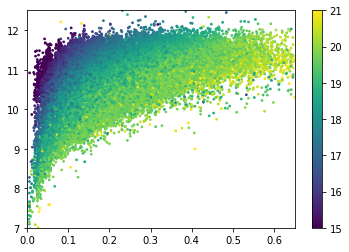

In [17]:
plt.scatter(gama_cat['Z'], gama_cat['logmintsfh'], c=gama_cat['MAG_AUTO_r'], 
            s=3, vmin=15, vmax=21)
plt.colorbar()

plt.xlim(0, 0.65)
plt.ylim(7, 12.5)

(8.0, 12.5)

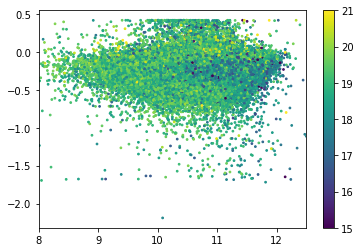

In [25]:
plt.scatter(gama_cat['logmintsfh'], np.log10(gama_cat['metal'] / 0.019), c=mags[:, 2],
            s=3, vmin=15, vmax=21)
plt.colorbar()

plt.xlim(8, 12.5)

In [26]:
np.sum(10**logsnrs[:, 0] < 3)

63463

In [18]:
np.save(f'./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch_{PHOT}.npy', mags)
np.save(f'./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch_{PHOT}.npy', z_mass_met)

---

### Noise model

`sigs` is defined as $\Delta m$

In [19]:
sigs = logsnrs

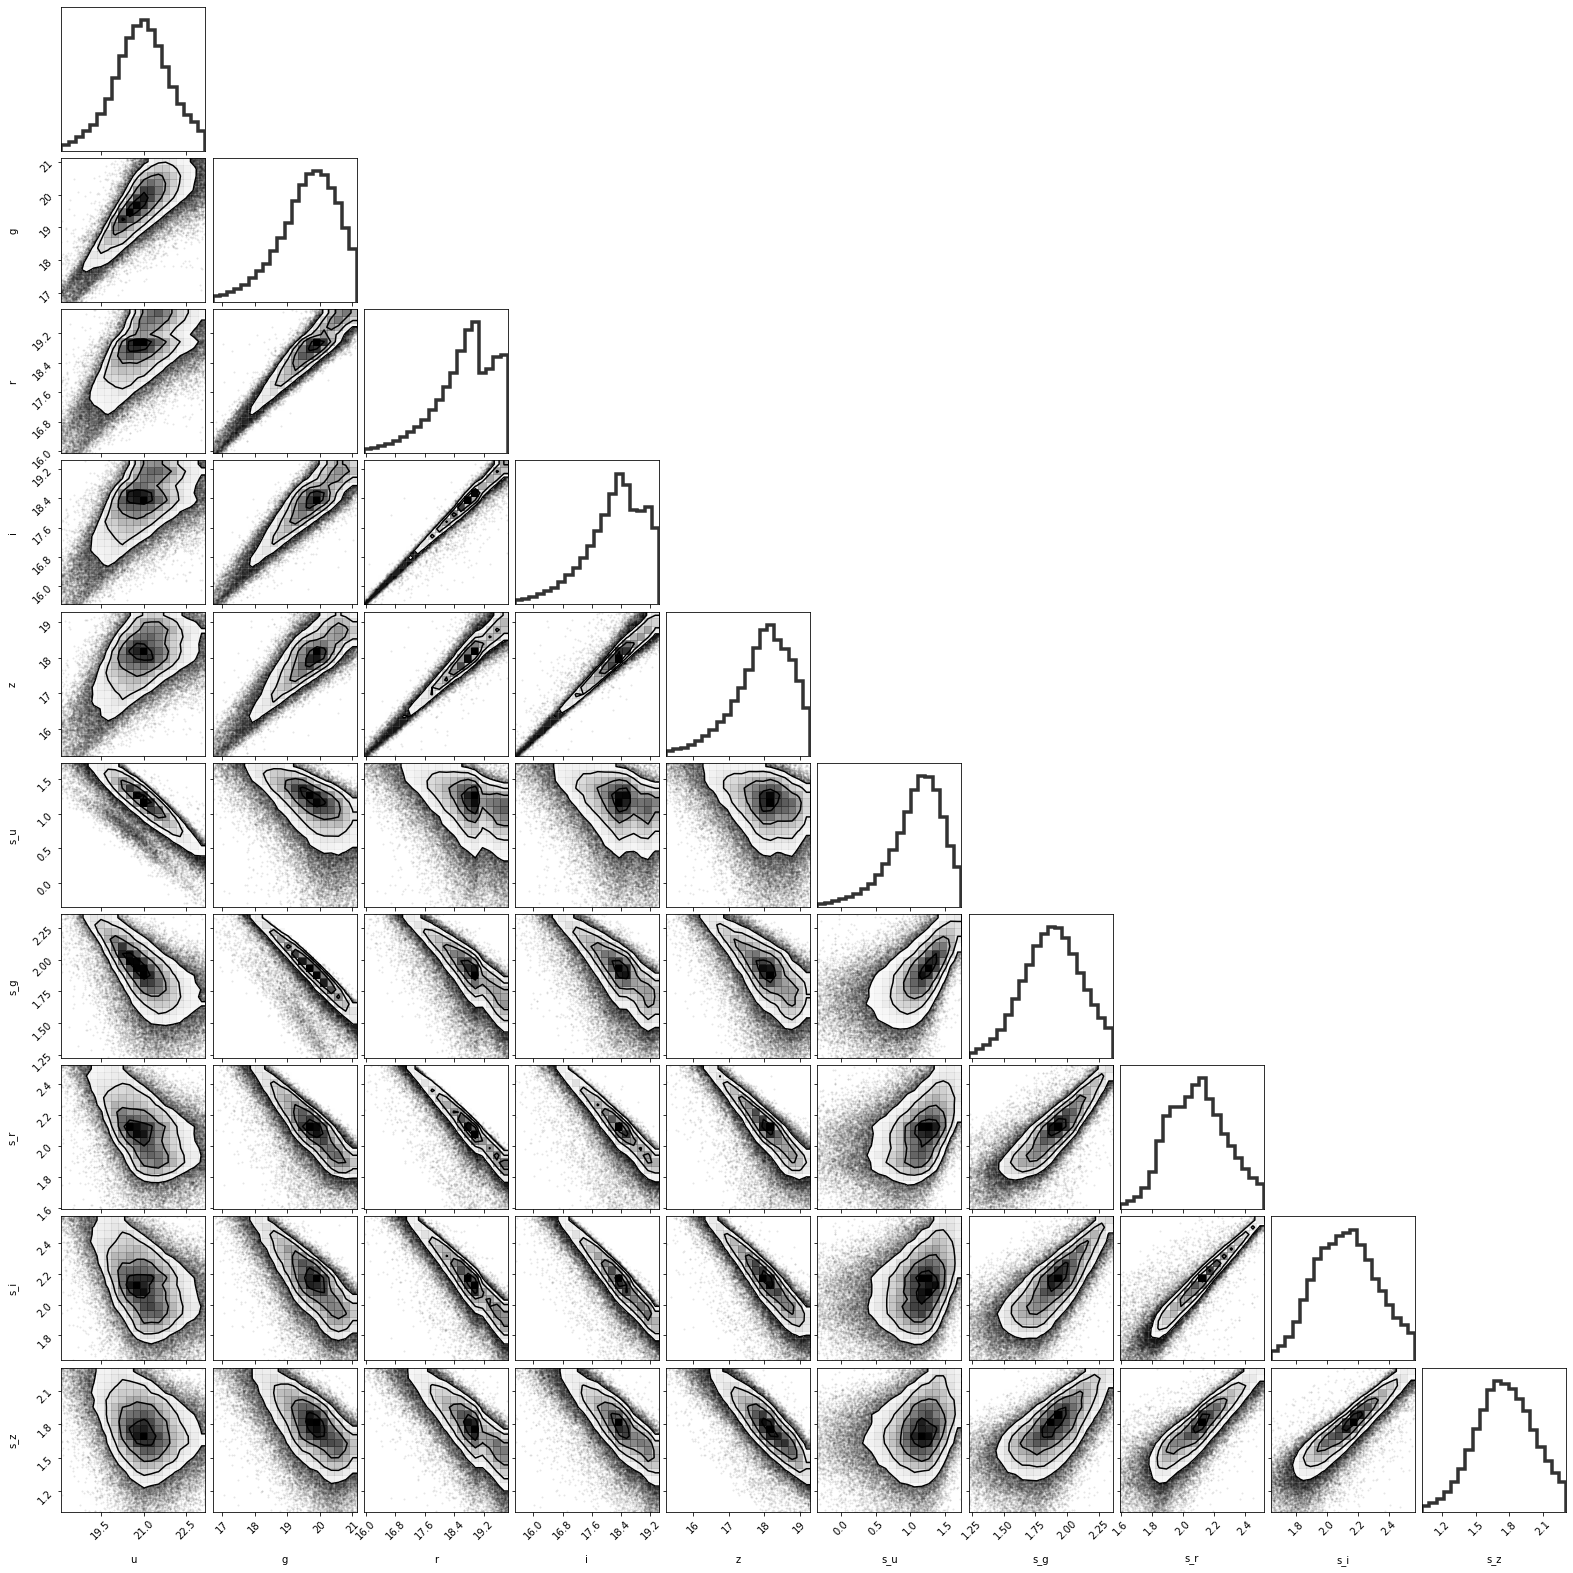

In [20]:
fig = corner.corner(np.concatenate([mags[:, :5], sigs[:, :5]], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags[:, :5], sigs[:, :5]], axis=1), 
                     [0.01, 0.95], axis=0).T,
                    labels=list('ugriz') + [f's_{filt}' for filt in list('ugriz')]) 

In [21]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [35]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
def trimmed_median(x): 
    xlim = np.quantile(x, [0.01, 0.99]) #0.998
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.01, 0.99])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

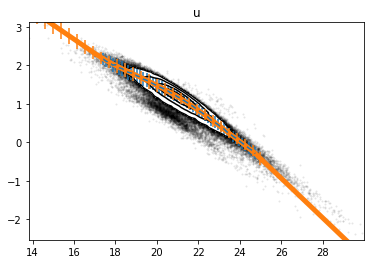

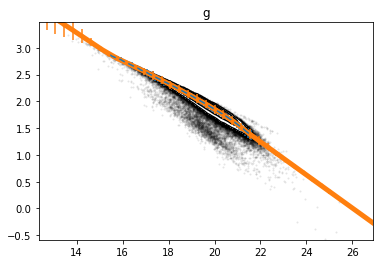

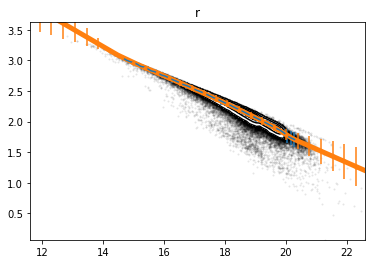

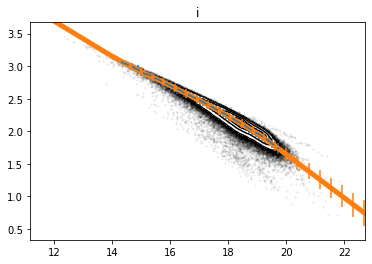

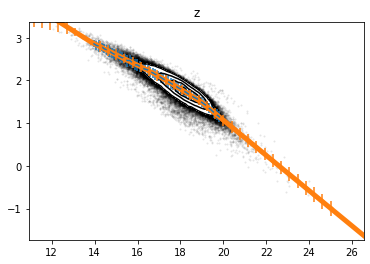

In [38]:
meds_sigs, stds_sigs = [], [] 

# for i in range(len(filters)): 
for i in range(5): #range(len(filters)): 
    clean = (np.isfinite(mags[:,i]))# & (sigs[:,i] < np.max([np.quantile(sigs[:,i], 0.99), 0.5])))
    
    low = 0.003 if i == 0 else 0.001
    med_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_median, 
                                              range=np.nanquantile(mags[clean,i], [low, 0.99]), bins=50)
    std_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_std, 
                                              range=np.nanquantile(mags[clean,i], [low, 0.99]), bins=50)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], 
                              fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], 
                              fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags[clean,i], sigs[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 35, 40), meds_sigs[-1](np.linspace(10, 35, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
#     sub.set_xlim(np.nanquantile(mags[clean,i], [0.01, 1.]))
#     sub.set_ylim(np.nanquantile(sigs[clean,i], [0.0, 0.995]))
    
    sub.set_title(filters[i])

In [39]:
np.save(f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}.npy', np.vstack([meds_sigs, stds_sigs]))

---

In [180]:
maggies = fluxes[:, 0]
_noise = maggies / 10**logsnrs[:, 0] * np.random.normal(size=len(maggies))
maggies_new = maggies + _noise

_noise[(maggies + _noise) < 0] = 0.0
maggies_new1 = maggies + _noise

In [181]:
maggies = fluxes[:, 0]
_noise = maggies / 10**logsnrs[:, 0] * np.random.normal(size=len(maggies))

In [182]:
i = 0
while np.any((maggies + _noise) < 0):
    i += 1
    _noise[(maggies + _noise) < 0] = (maggies / 10**logsnrs[:, 0] * np.random.normal(size=len(maggies)))[(maggies + _noise) < 0]
    if i > 1000:
        _noise[(maggies + _noise) < 0] = 1e5
        break

In [183]:
maggies_new2 = maggies + _noise

In [184]:
(maggies_new2 < 0).sum()

0

Text(0.5, 0, 'Flux')

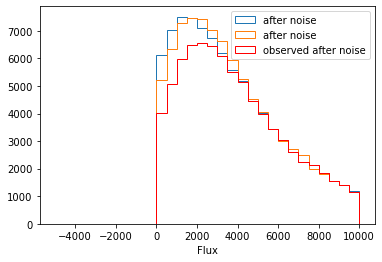

In [185]:
# plt.hist(maggies, bins=30, range=(-0.5e4, 1e4), histtype='step', label='before noise', density=False)
plt.hist(maggies_new1, bins=30, range=(-0.5e4, 1e4), histtype='step', label='after noise', density=False)
plt.hist(maggies_new2, bins=30, range=(-0.5e4, 1e4), histtype='step', label='after noise', density=False)
plt.hist(maggies_new[maggies_new > 0], bins=30, range=(-0.5e4, 1e4), histtype='step', color='r', label='observed after noise', density=False)

plt.legend()
plt.xlabel('Flux')
# plt.xscale('log')

Text(0.5, 0, 'Flux')

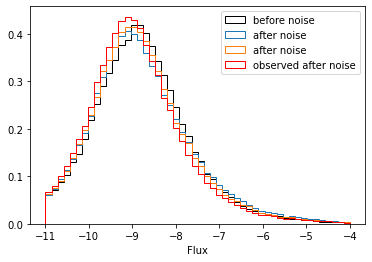

In [193]:
plt.hist(-2.5 * np.log10(maggies), bins=50, range=(-11, -4), histtype='step', color='k', label='before noise', density=True)
plt.hist(-2.5 * np.log10(maggies_new1), bins=50, range=(-11, -4), histtype='step', label='after noise', density=True)
plt.hist(-2.5 * np.log10(maggies_new2), bins=50, range=(-11, -4), histtype='step', label='after noise', density=True)
plt.hist(-2.5 * np.log10(maggies_new[maggies_new > 0]), bins=50, range=(-11, -4), histtype='step', color='r', label='observed after noise', density=True)

plt.legend()
plt.xlabel('Flux')
# plt.xscale('log')

In [136]:
maggies = 1
_noise = 1 * np.random.normal(size=10000)
maggies_new = maggies + _noise

In [137]:
_noise[(maggies + _noise) < 0] = 0
maggies_new1 = maggies + _noise

In [139]:
maggies_new1[maggies_new1 > 0].shape

(10000,)

In [128]:
i = 0
while np.any(x0 < 0):
    i += 1
    _noise[(maggies + _noise) < 0] = (1 * np.random.normal(size=10000))[(maggies + _noise) < 0]
    if i > 100:
        _noise[(maggies + _noise) < 0] = 0.0
        break

In [129]:
maggies_new2 = maggies + _noise
(maggies_new2 < 0).sum()

0

In [130]:
maggies

1

Text(0.5, 0, 'Flux')

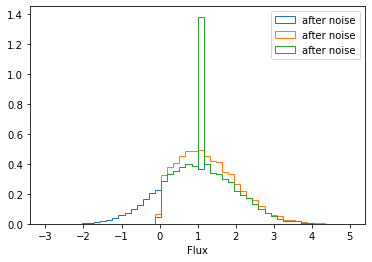

In [140]:
# plt.hist(maggies, bins=50, range=(-3, 5), histtype='step', label='before noise', density=True)
plt.hist(maggies_new, bins=50, range=(-3, 5), histtype='step', label='after noise', density=True)
plt.hist(maggies_new2, bins=50, range=(-3, 5), histtype='step', label='after noise', density=True)
plt.hist(maggies_new1, bins=50, range=(-3, 5), histtype='step', label='after noise', density=True)
# plt.hist(maggies_new[maggies_new > 0], bins=50, range=(-3, 5), histtype='step', color='r', 
#          label='observed after noise', density=True)

plt.legend()
plt.xlabel('Flux')
# plt.xscale('log')

Total number of samples: 97859
Total number of samples: 102637


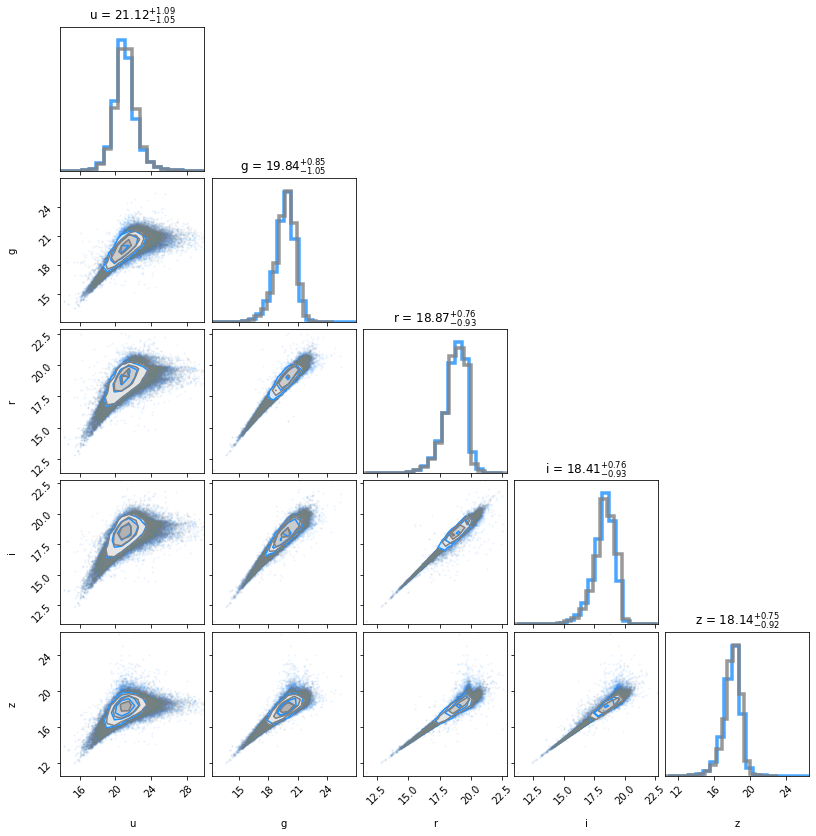

In [62]:
X_data = np.load(f'./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch_{PHOT}.npy')[:, :5]
print('Total number of samples:', len(X_data))

labels = list('ugriz')

figure = corner.corner(X_data,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})


X_data = np.load(f'./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy')[:, :5]
print('Total number of samples:', len(X_data))

labels = list('ugriz')

figure = corner.corner(X_data,
                       fig=figure,
                       color='gray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})